Model

In [17]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score,roc_auc_score,confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

Read the file

In [18]:
df=pd.read_csv("train_hsbc_df.csv")

Clean The dataset

In [19]:
df_cleaned = df.copy()
for col in ['customer', 'age', 'gender', 'zipcodeOri', 'merchant', 'zipMerchant', 'category']:
    df_cleaned[col] = df_cleaned[col].str.replace("'", "")

In [20]:

df_cleaned['amount'] = df_cleaned['amount'].astype(float)


Check Imbalance

In [21]:
#checking class imbalance
class_distribution = df_cleaned['fraud'].value_counts(normalize=True)*100
class_distribution

fraud
0    98.792936
1     1.207064
Name: proportion, dtype: float64

In [22]:
df_encoded = df_cleaned.copy()
for col in ['customer', 'age', 'gender', 'zipcodeOri', 'merchant', 'zipMerchant', 'category']:
    df_encoded[col] = df_encoded[col].astype('category').cat.codes

Co relation Matrix

In [ ]:
correlation_matrix = df_encoded.corr()
fraud_correlations = correlation_matrix['fraud'].sort_values(ascending=False)

fraud_correlations
plt.figure(figsize=(10, 6))
sns.barplot(x=fraud_correlations.index, y=fraud_correlations.values, palette='viridis')

# x and y label
plt.xlabel('Features')
plt.ylabel('Correlation with Fraud')
plt.title('Correlation')

plt.tight_layout()
plt.show()


Train and Test

In [24]:
X = df_cleaned.drop('fraud', axis=1)
y = df_cleaned['fraud']

     # Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)


Create a Pipeline

In [25]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Identify numeric and categorical columns
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X.select_dtypes(include=['object']).columns

# Create preprocessing pipelines for numeric and categorical data
numeric_pipeline = Pipeline([
    ('scaler', StandardScaler())
])

categorical_pipeline = Pipeline([
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Combine pipelines into a full preprocessing pipeline
preprocessor = ColumnTransformer([
    ('num', numeric_pipeline, numeric_features),
    ('cat', categorical_pipeline, categorical_features)
])

# Preprocess training and test data
X_train_preprocessed = preprocessor.fit_transform(X_train)
X_test_preprocessed = preprocessor.transform(X_test)


XGBboost model

In [26]:
import xgboost as xgb
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.model_selection import train_test_split
# Initialize the XGBoost model
xgb_model = xgb.XGBClassifier(
    objective='binary:logistic',  # Binary classification
    eval_metric='logloss',        # Evaluation metric
    use_label_encoder=False,      # Avoid deprecated warning
    random_state=42
)

# Train the model
xgb_model.fit(X_train_preprocessed, y_train)


C:\Users\Khushi\Downloads\New folder\lib\site-packages\xgboost\core.py:158: UserWarning: [16:37:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, random_state=42, ...)

Predictions

In [41]:
# Make predictions
y_pred = xgb_model.predict(X_test_preprocessed)
y_proba = xgb_model.predict_proba(X_test_preprocessed)[:, 1]  # Probabilities for ROC-AUC

# Calculate metrics
print(classification_report(y_test, y_pred))
print(f'ROC-AUC: {roc_auc_score(y_test, y_proba)*100}')



              precision    recall  f1-score   support

           0       1.00      1.00      1.00    152233
           1       0.89      0.80      0.85      1860

    accuracy                           1.00    154093
   macro avg       0.94      0.90      0.92    154093
weighted avg       1.00      1.00      1.00    154093

ROC-AUC: 99.8415556614581


In [28]:
cm = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = cm.ravel()

print(f'False Positives: {fp}')
print(f'False Negatives: {fn}')

False Positives: 184
False Negatives: 363


In [ ]:
from sklearn.model_selection import GridSearchCV
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 6, 9],
    'min_child_weight': [1, 3, 5],
    'subsample': [0.7, 0.8, 0.9],
    'colsample_bytree': [0.7, 0.8, 0.9],
    'gamma': [0, 0.1, 0.2],
    'reg_alpha': [0, 0.1, 0.5],
    'reg_lambda': [1, 1.5, 2]
}
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, scoring='accuracy', cv=5, n_jobs=-1, verbose=2)
# Fit GridSearchCV
grid_search.fit(X_train_preprocessed, y_train)

# Get the best parameters
best_params = grid_search.best_params_
print(f'Best Parameters: {best_params}')

# Get the best model
best_xgb_model = grid_search.best_estimator_

# Evaluate the best model
y_pred = best_xgb_model.predict(X_test_preprocessed)
y_proba = best_xgb_model.predict_proba(X_test_preprocessed)[:, 1]

print(classification_report(y_test, y_pred))
print(f'ROC-AUC: {roc_auc_score(y_test, y_proba)}')

Fitting 5 folds for each of 19683 candidates, totalling 98415 fits


Feature that indicates to the merchant

                              Feature  Importance
4176         cat__merchant_M980657600    0.167863
4190  cat__category_es_transportation    0.093719
1                         num__amount    0.069580
4161         cat__merchant_M480139044    0.054548
4170         cat__merchant_M855959430    0.032810
4127        cat__merchant_M1053599405    0.032185
4186         cat__category_es_leisure    0.028438
4148        cat__merchant_M1873032707    0.028242
4150        cat__merchant_M1913465890    0.025405
4188   cat__category_es_sportsandtoys    0.020886
4172          cat__merchant_M85975013    0.019776
4129        cat__merchant_M1198415165    0.019084
4152        cat__merchant_M2011752106    0.017268
4189            cat__category_es_tech    0.016284
4133        cat__merchant_M1353266412    0.013539
4184   cat__category_es_hotelservices    0.011609
4166         cat__merchant_M692898500    0.011311
4134        cat__merchant_M1400236507    0.010932
4139        cat__merchant_M1649169323    0.010679


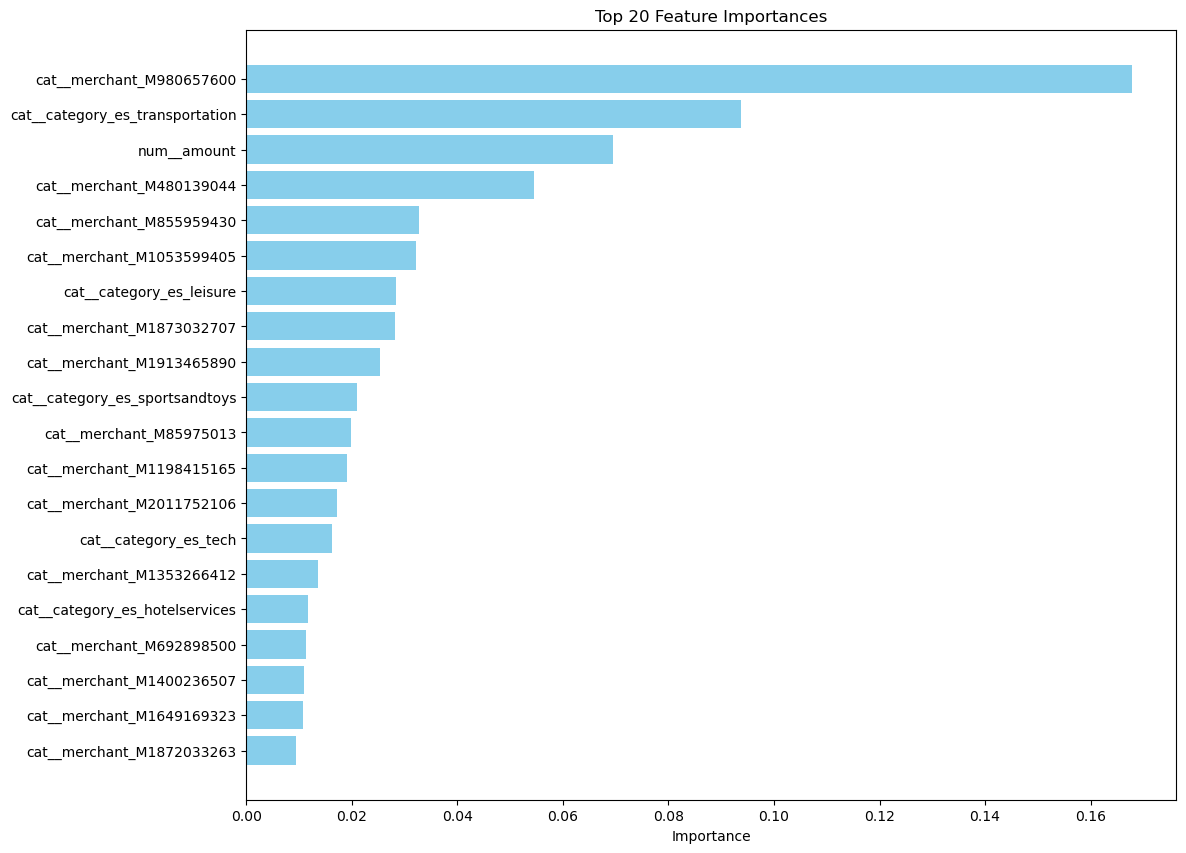

In [29]:
import pandas as pd
import matplotlib.pyplot as plt

# Get feature importances
importances = xgb_model.feature_importances_

# Create a DataFrame for feature importances
feature_names = preprocessor.get_feature_names_out()
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Select top 20 features
top_20_features = importance_df.head(20)

print(top_20_features)

# Plot top 20 feature importances
plt.figure(figsize=(12, 10))
plt.barh(top_20_features['Feature'], top_20_features['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.title('Top 20 Feature Importances')
plt.gca().invert_yaxis()
plt.show()


# Model 2 Random Forest

In [30]:
X = df_cleaned.drop('fraud', axis=1)
y = df_cleaned['fraud']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Identify numeric and categorical columns
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X.select_dtypes(include=['object']).columns

# Create preprocessing pipelines for numeric and categorical data
numeric_pipeline = Pipeline([
    ('scaler', StandardScaler())
])

categorical_pipeline = Pipeline([
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Combine pipelines into a full preprocessing pipeline
preprocessor = ColumnTransformer([
    ('num', numeric_pipeline, numeric_features),
    ('cat', categorical_pipeline, categorical_features)
])

# Preprocess training and test data
X_train_preprocessed = preprocessor.fit_transform(X_train)
X_test_preprocessed = preprocessor.transform(X_test)


In [39]:
from sklearn.ensemble import RandomForestClassifier

# Initialize the Random Forest model
rf_model = RandomForestClassifier(
    n_estimators=100,         # Number of trees in the forest
    max_depth=None,           # Maximum depth of each tree
    random_state=42           # Seed for reproducibility
)

# Train the model
rf_model.fit(X_train_preprocessed, y_train)

# Make predictions
y_pred = rf_model.predict(X_test_preprocessed)
y_proba = rf_model.predict_proba(X_test_preprocessed)[:, 1]  # Probabilities for ROC-AUC

# Calculate metrics
print(classification_report(y_test, y_pred))
print(f'ROC-AUC: {roc_auc_score(y_test, y_proba)*100}')


              precision    recall  f1-score   support

           0       1.00      1.00      1.00    152233
           1       0.89      0.80      0.84      1860

    accuracy                           1.00    154093
   macro avg       0.94      0.90      0.92    154093
weighted avg       1.00      1.00      1.00    154093

ROC-AUC: 99.39195216387667


In [47]:
import pandas as pd

# Assuming you have a test data DataFrame `X_test` with an 'ID' column for unique identifiers
# If you don't have an 'ID' column, you can use the index or create a new identifier

# For XGBoost Model
xgb_predictions = xgb_model.predict(X_test_preprocessed)
xgb_probabilities = xgb_model.predict_proba(X_test_preprocessed)[:, 1]

# Create DataFrame for XGBoost predictions
xgb_results_df = pd.DataFrame({
    'ID': X_test.index,  # or use X_test['ID'] if available
    'Predicted_Label': xgb_predictions,
    'Probability': xgb_probabilities
})

# Save to CSV
xgb_results_df.to_csv('xgb_predictions.csv', index=False)

# For Random Forest Model
rf_predictions = rf_model.predict(X_test_preprocessed)
rf_probabilities = rf_model.predict_proba(X_test_preprocessed)[:, 1]

# Create DataFrame for Random Forest predictions
rf_results_df = pd.DataFrame({
    'ID': X_test.index,  # or use X_test['ID'] if available
    'Predicted_Label': rf_predictions,
    'Probability': rf_probabilities
})

# Save to CSV
rf_results_df.to_csv('rf_predictions.csv', index=False)


In [48]:
from IPython.display import FileLink

# Generate a download link for the file
FileLink('xgb_predictions.csv')

C:\Users\Khushi\Desktop\xgb_predictions.csv

In [49]:
from IPython.display import FileLink

# Generate a download link for the file
FileLink('rf_predictions.csv')

C:\Users\Khushi\Desktop\rf_predictions.csv